### This code is a rewrite of DSAS.ipynb in the same working directory. DSAS.ipynb is a python notebook that is tested with 1860 and 1911 shoreline data. To make it more compatible, this code is written in a class format.

In [1]:
from shapely.geometry import Point, Polygon, LineString, MultiLineString,MultiPoint,MultiPolygon

In [2]:
from pyproj import Geod

In [3]:
import copy

In [4]:
import geojson

In [43]:
year_with_data={"Westport":[1700,1860,1911,1926,1942,1954,1967,1974,1986,1995,1997,1999,2001,2006,2015],
                "South Beach":[],
                "Ocean Shores":[]}

In [84]:
#get the number of layers of a nested list
def depth(l):
    if isinstance(l, list):
        return 1 + max(depth(item) for item in l)
    else:
        return 0

## When using this class to produce the shorelines, please be mindful that DO NOT input years that are surveyed!

Here I write a class to generate the transects. The class is called transects. The class takes three inputs:
- area: the area of interest, it takes three values: 'Westport", "South Beach", and "Ocean Shores"
- distance: given in the unit of miles. It determines the length of the transects, the code will only find the intersection points on the transects
- direction: the direction of the baseline. It takes two values: "clockwise" and "counterclockwise". Currently, the Westport takes clockwise and the other two areas take counterclockwise. But it can be changed as needed.
- year: the year you want to estimate the shorelines.

In [195]:
class transects:
    def __init__(self,area,distance,direction,year):
        self.area = area
        self.distance = distance
        self.direction = direction
        self.year = year
        

    #given a year, we need to know the adjacent two surveyed years
    def get_years(self):
        for i in range(len(year_with_data[self.area])-1):
            if year_with_data[self.area][i]<self.year<year_with_data[self.area][i+1]:
                prev=year_with_data[self.area][i]
                next=year_with_data[self.area][i+1]
                break
        return prev,next




    def get_baseline(self):
        if self.area=="Westport":
            self.baseline=[Point([-124.109126, 46.858710]), Point([-124.117791, 46.887093]),Point([-124.115168, 46.896011]),Point([-124.108546,46.895850]),Point([-124.105023,46.88691]),Point([-124.104452,46.858904])]
        elif self.area=="South Beach":
            self.baseline=[Point()]
        elif self.area=="Ocean Shores":
            self.baseline=[]

        return self.baseline

    #in get_baseline, we have already defined the control points of the baseline, now, we need to get the foot of transects on the baseline
    def get_transect_foots(self):
        #self.transects_foots=[]
        self.base=self.get_baseline()
        self.transects_foots=[self.base[0]]
        for i in range(0,len(self.base)-1):
            ab=LineString([self.base[i],self.base[i+1]])
            
            self.transects_foots.extend([ab.interpolate(i/60, normalized=True) for i in range(0,60)])
        return self.transects_foots

    def get_transects(self):
        self.geod = Geod(ellps='WGS84')   #the projection system is WGS84
        self.transects=[]
        self.foots=self.get_transect_foots()
        for i in range(0,len(self.foots)-1):
            lon1,lat1=self.foots[i].x,self.foots[i].y
            lon2,lat2=self.foots[i+1].x,self.foots[i+1].y

            #calculate the azimuth of the transect
            f_azimuth, b_azimuth,_ = self.geod.inv(lon1, lat1, lon2, lat2)

            #calculate the direction of the transect, it could either rotate clockwise or counterclockwise

            if self.direction=="clockwise":
                if b_azimuth<270:
                    azimuth=b_azimuth+90
                else:
                    azimuth=b_azimuth-270
            else:
                if b_azimuth>90:
                    azimuth=b_azimuth-90
                else:
                    azimuth=b_azimuth+270

            #calculate the other point of the transect
            # Calculate the coordinates of the points away from the original line

            offset_lon1, offset_lat1, _ = self.geod.fwd(lon1, lat1, azimuth, self.distance * 1609.34)
            offset_lon2, offset_lat2, _ = self.geod.fwd(lon2, lat2, azimuth, self.distance * 1609.34)

            # Create the line
            transect=LineString([(lon2,lat2),(offset_lon2,offset_lat2)])
            self.transects.append(transect)
        return self.transects

    #create a function to get the ORIGINAL shoreline files
    #given a year of interest, two shoreline files should be pulled

    def read_shoreline(self):
        for i in range(len(year_with_data[self.area])-1):
            if year_with_data[self.area][i]<self.year<year_with_data[self.area][i+1]:
                if year_with_data[self.area][i] in [1700,1860,1911]:
                    with open("shore_"+str(year_with_data[self.area][i])+".geojson") as f:
                        gj=geojson.load(f)
                    features_prev=gj["features"]
                elif year_with_data[self.area][i]==2006:
                    with open ("ECY_historical_shorelines_epsg32149/2005or_2006wa.geojson") as f:
                        gj=geojson.load(f)
                    features_prev=gj["features"]
                elif year_with_data[self.area][i]==2015:
                    with open ("ECY_historical_shorelines_epsg32149/2015wa_2016or.geojson") as f:
                        gj=geojson.load(f)
                    features_prev=gj["features"]
                else:
                    with open("ECY_historical_shorelines_epsg32149/"+str(year_with_data[self.area][i])+".geojson") as f:
                        gj=geojson.load(f)
                    features_prev=gj["features"]

                if year_with_data[self.area][i+1] in [1700,1860,1911]:
                    with open("shore_"+str(year_with_data[self.area][i+1])+".geojson") as f:
                        gj=geojson.load(f)
                    features_next=gj["features"]
                elif year_with_data[self.area][i+1]==2006:
                    with open ("ECY_historical_shorelines_epsg32149/2005or_2006wa.geojson") as f:
                        gj=geojson.load(f)
                    features_next=gj["features"]
                elif year_with_data[self.area][i+1]==2015:
                    with open ("ECY_historical_shorelines_epsg32149/2015wa_2016or.geojson") as f:
                        gj=geojson.load(f)
                    features_next=gj["features"]
                else:
                    with open("ECY_historical_shorelines_epsg32149/"+str(year_with_data[self.area][i+1])+".geojson") as f:
                        gj=geojson.load(f)
                    features_next=gj["features"]
                break
            
            elif year_with_data[self.area][i]==self.year:
                        
                if year_with_data[self.area][i] in [1700,1860,1911]:
                    with open("shore_"+str(year_with_data[self.area][i])+".geojson") as f:
                        gj=geojson.load(f)
                    features_prev=gj["features"]
                elif year_with_data[self.area][i]==2006:
                    with open ("ECY_historical_shorelines_epsg32149/2005or_2006wa.geojson") as f:
                        gj=geojson.load(f)
                    features_prev=gj["features"]
                elif year_with_data[self.area][i]==2015:
                    with open ("ECY_historical_shorelines_epsg32149/2015wa_2016or.geojson") as f:
                        gj=geojson.load(f)
                    features_prev=gj["features"]
                else:
                    with open("ECY_historical_shorelines_epsg32149/"+str(year_with_data[self.area][i])+".geojson") as f:
                        gj=geojson.load(f)
                    features_prev=gj["features"]

                if year_with_data[self.area][i+1] in [1700,1860,1911]:
                    with open("shore_"+str(year_with_data[self.area][i+1])+".geojson") as f:
                        gj=geojson.load(f)
                    features_next=gj["features"]
                elif year_with_data[self.area][i+1]==2006:
                    with open ("ECY_historical_shorelines_epsg32149/2005or_2006wa.geojson") as f:
                        gj=geojson.load(f)
                    features_next=gj["features"]
                elif year_with_data[self.area][i+1]==2015:
                    with open ("ECY_historical_shorelines_epsg32149/2015wa_2016or.geojson") as f:
                        gj=geojson.load(f)
                    features_next=gj["features"]
                else:
                    with open("ECY_historical_shorelines_epsg32149/"+str(year_with_data[self.area][i+1])+".geojson") as f:
                        gj=geojson.load(f)
                    features_next=gj["features"]
                break


        self.dict_shoreline={"previous":features_prev,"next":features_next}
        return self.dict_shoreline

    #convert the Original shoreline files into a list of linestrings
    def shoreline_to_linestring(self):
        self.shoreline_origin=self.read_shoreline()
        list_str_prev=[]
        list_str_next=[]
        for i in range(len(self.shoreline_origin["previous"])):
            if depth(self.shoreline_origin["previous"][i]["geometry"]['coordinates'])==3:
                list_str_prev.append(LineString(self.shoreline_origin["previous"][i]["geometry"]['coordinates'][0]))  #IF THE SHORELINE IS A MULTILINESTRING, CHANGE THE INDEX TO 0
            else:
                list_str_prev.append(LineString(self.shoreline_origin["previous"][i]["geometry"]['coordinates']))  #IF THE SHORELINE IS A MULTILINESTRING, CHANGE THE INDEX TO 0
        for i in range(len(self.shoreline_origin["next"])):
            if depth(self.shoreline_origin["next"][i]["geometry"]['coordinates'])==3:

                list_str_next.append(LineString(self.shoreline_origin["next"][i]["geometry"]['coordinates'][0]))       #OTHERWISE, DELETE THE INDEX 0
            else:
                list_str_next.append(LineString(self.shoreline_origin["next"][i]["geometry"]['coordinates']))

        self.dict_str_shorelines={"previous":list_str_prev,"next":list_str_next}

        return self.dict_str_shorelines

    #this function is to draw a crop area. Only shoreline within the crop area will be used to calculate the intersection
    def draw_crop(self):
        if self.area=="Westport":
            self.crop=Polygon([(-124.168153,46.858267), (-124.168153, 46.917317), (-124.087369, 46.917317), (-124.087369, 46.880483),(-124.097723,46.879295),(-124.091375,46.867738),(-124.091375,46.858267)])
        elif self.area=="South Beach":
            self.crop=Polygon()
        elif self.area=="Ocean Shores":
            self.crop=Polygon()

        return self.crop

    #this function is to delete linestrings that falls out of the crop area
    #output is a dictionary
    #first value is the previous year shoreline
    #second value is the next year shoreline
    def clean_shoreline(self):
        self.shoreline_first=self.shoreline_to_linestring()["previous"]
        self.shoreline_last=self.shoreline_to_linestring()["next"]
        for i in range(len(self.shoreline_first)):
            self.shoreline_first[i]=self.shoreline_first[i].intersection(self.draw_crop())
        for i in range(len(self.shoreline_last)):
            self.shoreline_last[i]=self.shoreline_last[i].intersection(self.draw_crop())

        #after the for loop, we have some linestrings that are empty. We need to delete them
        self.shoreline_first_c=copy.copy(self.shoreline_first)
        self.shoreline_last_c=copy.copy(self.shoreline_last)
        for feature in self.shoreline_first:
            if feature.is_empty==True:
                self.shoreline_first_c.remove(feature)

        for feature in self.shoreline_last:
            if feature.is_empty==True:
                self.shoreline_last_c.remove(feature)

        del self.shoreline_first
        del self.shoreline_last
        self.shoreline_first=self.shoreline_first_c
        self.shoreline_last=self.shoreline_last_c
        del self.shoreline_first_c
        del self.shoreline_last_c

        self.cleaned_shoreline={"previous":self.shoreline_first,"next":self.shoreline_last}

        return self.cleaned_shoreline

    # this function is in change of finding the intersection 
    # between the transect and the cleaned shoreline
    def find_intersections(self):
        self.transects_list=self.get_transects()
        self.shoreline_previous=self.clean_shoreline()["previous"]
        self.shoreline_next=self.clean_shoreline()["next"]
        intersection_dict={}
        

        # the first loop will return the transects
        for k,transect in enumerate(self.transects_list):
            transect_dict={}
            first=Point(transect.coords[0])
            
            #the transects may intersect with more than
            #one segment of the shoreline
            #so we create a list named tmp to store all the intersections
            #but we will compare the distance of all of those intersections
            #and only keep the furthest one
            tmp=[]
            i=0
            for shoreline_p in self.shoreline_previous:
                if transect.intersects(shoreline_p):
                    # if there are multiple intersection points, we select the point that is furthest
                    if type(transect.intersection(shoreline_p))==MultiPoint:
                        distances=[first.distance(pt) for pt in list(transect.intersection(shoreline_p).geoms)] #find the distance between the start point and the intersection points
                        furthest_point = max(zip(distances, list(transect.intersection(shoreline_p).geoms)))[1]
                        tmp.append(furthest_point)
                    else:
                        tmp.append(transect.intersection(shoreline_p))
                else:
                    i+=1
            if i==len(self.shoreline_previous):
                transect_dict["shores_early"]="Did Not Intersect with early"
            #there may be more than one 
            else:
                distance=[first.distance(pt) for pt in tmp]
                furthest_point = max(zip(distance, tmp))[1]
                transect_dict["shores_early"]=furthest_point


            tmp=[]
            i=0
            for shoreline_n in self.shoreline_next:
                if transect.intersects(shoreline_n):
                    if type(transect.intersection(shoreline_n))== MultiPoint:
                        distances=[first.distance(pt) for pt in list(transect.intersection(shoreline_n).geoms)]
                        furthest_point = max(zip(distances, list(transect.intersection(shoreline_n).geoms)))[1]
                        tmp.append(furthest_point)
                    else:
                        tmp.append(transect.intersection(shoreline_n))
                else:
                    i+=1
            if i == len(self.shoreline_next):
                
                transect_dict["shores_late"]="Did Not Intersect with later"
            else:
                distance=[first.distance(pt) for pt in tmp]
                furthest_point = max(zip(distance, tmp))[1]
                transect_dict["shores_late"]=furthest_point
        
            intersection_dict["tran_"+str(k)]=transect_dict

        return intersection_dict

    #this function divides transects into yearly equal parts
    #The interpolation includes the end point, but not the start point.
    def shoreline_divide(self):
        ins_dict=self.find_intersections()
        for key in ins_dict.keys():
            if ins_dict[key]["shores_early"]!="Did Not Intersect with early" and ins_dict[key]["shores_late"]!="Did Not Intersect with later":
                line=LineString([ins_dict[key]["shores_early"],ins_dict[key]["shores_late"]])
                ins_dict[key]["interpolation"]=[line.interpolate((i+1)/(self.get_years()[1] -self.get_years()[0]), normalized=True) for i in range(self.get_years()[1] - self.get_years()[0])]
            else:
                ins_dict[key]["interpolation"]="Did not interpolate"
        return ins_dict


    def shoreline_estimated(self):
        #shorelines_estimated={}
        tmp_shoreline=[]
        st_year=self.get_years()[0]
        div_shoreline=self.shoreline_divide()
        for key in self.shoreline_divide().keys():
            if div_shoreline[key]["interpolation"]!="Did not interpolate":
                tmp_shoreline.append(div_shoreline[key]["interpolation"][self.year-st_year-1])
        tmp_shoreline=LineString(tmp_shoreline)
        return tmp_shoreline


        





        


In [27]:
class Westport(transects):
    def __init__(self,distance,direction,year):
        super().__init__("Westport",distance,direction,year)

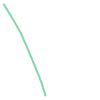

In [196]:
#test cell
t=transects("Westport",1,"clockwise",1945)
#t.get_transect_foots()
#print(t.shoreline_to_linestring()["next"][0].intersection(t.draw_crop()).is_empty)
#t.clean_shoreline()["next"]
#t.shoreline_to_linestring()["previous"]
t.shoreline_estimated()

## Output as a geojson file

In [200]:
for i in range(0,5):
    print(i)

0
1
2
3
4


In [201]:
# we can only estimate the historical shoreline for the years between 1701 and 2014.
city_name="Westport"         #change the city name here

for year in range(1701,2015):
    if year in year_with_data[city_name]:         
        continue
    else:
        w=transects(city_name,1,"clockwise",year)      #transects here is the class name
        line_geojson=geojson.Feature(geometry=w.shoreline_estimated().__geo_interface__, properties={})   #shoreline_estimated() is the function in class which output the final estimated shoreline
        with open("ECY_estimated_shorelines/"+str(year)+".geojson", 'w', encoding='utf-8') as f:
            geojson.dump(line_geojson, f, ensure_ascii=False, indent=4)

TypeError: 'NoneType' object is not subscriptable

In [198]:
line_geojson = geojson.Feature(geometry=t.shoreline_estimated().__geo_interface__, properties={})

In [199]:
line_geojson

{"geometry": {"coordinates": [[-124.115001, 46.858359], [-124.115133, 46.858834], [-124.115276, 46.859307], [-124.115427, 46.85978], [-124.115586, 46.86025], [-124.115756, 46.86072], [-124.115912, 46.861191], [-124.116066, 46.861663], [-124.1162, 46.862138], [-124.116294, 46.862618], [-124.116442, 46.86309], [-124.116595, 46.863562], [-124.116744, 46.864035], [-124.116914, 46.864504], [-124.117109, 46.86497], [-124.117304, 46.865436], [-124.117499, 46.865901], [-124.117653, 46.866373], [-124.117797, 46.866846], [-124.117991, 46.867312], [-124.118203, 46.867776], [-124.118416, 46.868239], [-124.118628, 46.868702], [-124.118813, 46.869169], [-124.118995, 46.869637], [-124.119178, 46.870104], [-124.119364, 46.870572], [-124.119551, 46.871039], [-124.119738, 46.871506], [-124.119924, 46.871973], [-124.120113, 46.872439], [-124.120304, 46.872906], [-124.120495, 46.873372], [-124.120686, 46.873838], [-124.120877, 46.874305], [-124.121068, 46.874771], [-124.121276, 46.875235], [-124.12146, 46

In [197]:
print(t.shoreline_estimated())

LINESTRING (-124.11500146249969 46.85835923847824, -124.11513302217914 46.85883415117187, -124.11527616213675 46.85930739924694, -124.11542653558449 46.859779607589914, -124.11558636986214 46.86025045610873, -124.11575614911919 46.860719875287394, -124.11591153166063 46.86119136383713, -124.11606649356936 46.861662912899256, -124.11620031797061 46.86213750000392, -124.1162938903814 46.8626178721712, -124.11644196489983 46.86309041103941, -124.11659479861069 46.863562265947586, -124.11674371265354 46.86403468421319, -124.11691419533793 46.86450400282234, -124.117109073731 46.86496981566282, -124.11730395222975 46.865435628745225, -124.11749883083402 46.86590144206923, -124.1176525789052 46.8663731661951, -124.11779678893299 46.86684626098134, -124.11799073435266 46.867312208938344, -124.11820296393248 46.86777552981472, -124.11841552016631 46.86823880409904, -124.1186282432306 46.86870205475833, -124.11881275330515 46.869169359601, -124.1189950310206 46.86963698540279, -124.119178451267

In [ ]:
for year in range(1945,2019):
    t=transects("Westport",1,"clockwise",year)
    print(t.shoreline_estimated().length)

In [152]:
print(t.get_years())

(1942, 1954)


In [161]:
print(t.shoreline_divide()["tran_1"]["shores_early"])
print(t.shoreline_divide()["tran_1"]["shores_late"])

POINT (-124.11499432315631 46.85836026472607)
POINT (-124.11507489194437 46.858348683332764)


ERROR 1: PROJ: proj_create_from_database: /usr/local/Caskroom/miniconda/base/envs/geo/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


CRSError: The WKT could not be parsed. OGR Error code 6

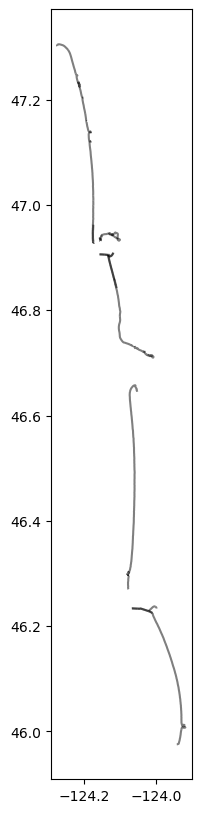

In [194]:
import geopandas as gpd
import contextily as ctx
import rasterio
from rasterio.plot import show as rioshow
import matplotlib.pyplot as plt

# Load GeoJSON data from file
data = gpd.read_file('ECY_historical_shorelines_epsg32149/2005or_2006wa.geojson')

ax = data.plot(figsize=(10,10), alpha=0.5, edgecolor='k')

ctx.add_basemap(ax, crs=data.crs.to_string())



In [186]:
data.crs

<Derived Projected CRS: EPSG:32149>
Name: NAD83 / Washington South
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [160]:
t.shoreline_divide()

{'tran_0': {'shores_early': 'Did Not Intersect with early',
  'shores_late': 'Did Not Intersect with later',
  'interpolation': 'Did not interpolate'},
 'tran_1': {'shores_early': <POINT (-124.115 46.858)>,
  'shores_late': <POINT (-124.115 46.858)>,
  'interpolation': [<POINT (-124.115 46.858)>,
   <POINT (-124.115 46.858)>,
   <POINT (-124.115 46.858)>,
   <POINT (-124.115 46.858)>,
   <POINT (-124.115 46.858)>,
   <POINT (-124.115 46.858)>,
   <POINT (-124.115 46.858)>,
   <POINT (-124.115 46.858)>,
   <POINT (-124.115 46.858)>,
   <POINT (-124.115 46.858)>,
   <POINT (-124.115 46.858)>,
   <POINT (-124.115 46.858)>]},
 'tran_2': {'shores_early': <POINT (-124.115 46.859)>,
  'shores_late': <POINT (-124.115 46.859)>,
  'interpolation': [<POINT (-124.115 46.859)>,
   <POINT (-124.115 46.859)>,
   <POINT (-124.115 46.859)>,
   <POINT (-124.115 46.859)>,
   <POINT (-124.115 46.859)>,
   <POINT (-124.115 46.859)>,
   <POINT (-124.115 46.859)>,
   <POINT (-124.115 46.859)>,
   <POINT (-12

In [159]:
print(t.shoreline_divide()["tran_1"]["interpolation"][0])

POINT (-124.11500103722199 46.858359299609965)


In [144]:
t.get_years()[1]-t.get_years()[0]

12

In [131]:
#test cell
t.get_transects()

[<LINESTRING (-124.109 46.859, -124.088 46.859)>,
 <LINESTRING (-124.109 46.859, -124.13 46.856)>,
 <LINESTRING (-124.109 46.86, -124.13 46.857)>,
 <LINESTRING (-124.11 46.86, -124.13 46.857)>,
 <LINESTRING (-124.11 46.861, -124.13 46.858)>,
 <LINESTRING (-124.11 46.861, -124.131 46.858)>,
 <LINESTRING (-124.11 46.862, -124.131 46.859)>,
 <LINESTRING (-124.11 46.862, -124.131 46.859)>,
 <LINESTRING (-124.11 46.862, -124.131 46.86)>,
 <LINESTRING (-124.11 46.863, -124.131 46.86)>,
 <LINESTRING (-124.111 46.863, -124.131 46.86)>,
 <LINESTRING (-124.111 46.864, -124.131 46.861)>,
 <LINESTRING (-124.111 46.864, -124.132 46.861)>,
 <LINESTRING (-124.111 46.865, -124.132 46.862)>,
 <LINESTRING (-124.111 46.865, -124.132 46.862)>,
 <LINESTRING (-124.111 46.866, -124.132 46.863)>,
 <LINESTRING (-124.111 46.866, -124.132 46.863)>,
 <LINESTRING (-124.112 46.867, -124.132 46.864)>,
 <LINESTRING (-124.112 46.867, -124.132 46.864)>,
 <LINESTRING (-124.112 46.868, -124.133 46.865)>,
 <LINESTRING (-1

In [109]:
#test cell
t2=transects("Westport",1,"clockwise",1853)
t2.shoreline_to_linestring()["next"]
#t2.clean_shoreline()["next"]
#t2.shoreline_to_linestring()["next"]==t2.clean_shoreline()["next"]



[<LINESTRING (-124.118 46.877, -124.118 46.878, -124.118 46.879, -124.118 46....>]

In [114]:
import geopandas as gpd

In [124]:
gpd.read_file("ECY_historical_shorelines_epsg2856/shore_1942.geojson")

,id,YEAR,MONTH,DAY,PHOTO_,Shape_Leng,geometry
0,0,1942,7,0,gra_md,899.055501,"LINESTRING (-124.14354 46.90581, -124.13175 46..."
1,1,1942,7,0,gra_md,2703.027041,"LINESTRING (-124.16220 46.90647, -124.16523 46..."
2,2,1942,7,0,gra_md,1401.059107,"LINESTRING (-124.16180 46.90614, -124.15911 46..."
3,3,1942,7,0,gra_md,1201.276320,"LINESTRING (-124.13083 46.89460, -124.13160 46..."
4,4,1942,7,0,gra_md,602.662308,"LINESTRING (-124.14344 46.90545, -124.13553 46..."
...,...,...,...,...,...,...,...
135,135,1942,8,0,USGS,7022.435033,"LINESTRING (-123.93551 46.08070, -123.93489 46..."
136,136,1942,8,0,USGS,493.174313,"LINESTRING (-123.92306 46.01168, -123.92334 46..."
137,137,1942,8,0,USGS,277.085147,"LINESTRING (-123.92604 46.01194, -123.92627 46..."
138,138,1942,8,0,USGS,201.420617,"LINESTRING (-123.93575 46.08250, -123.93551 46..."


In [83]:
depth(t2.read_shoreline()["next"][0]["geometry"]["coordinates"])

3

In [19]:
len(t.get_transects())

300

In [22]:
class Animal:
    def __init__(self, name, species):
        self.name = name
        self.species = species
    
    def speak(self):
        print("Generic animal sound.")
    
    def run(self):
        if self.species == "cat":
            print("Running...cat")
        else:
            print("Running...")

class Dog(Animal):
    def __init__(self, name):
        super().__init__(name, "dog")
    
    def speak(self):
        print("Woof!")

class Cat(Animal):
    def __init__(self, name):
        super().__init__(name, "cat")
    
    def speak(self):
        print("Meow!")

animal = Animal("Generic Animal", "unknown")
dog = Dog("Fido")
cat = Cat("Fluffy")

#animal.speak()  # Output: Generic animal sound.
#dog.speak()  # Output: Woof!
cat.run()  # Output: Meow!


Running...cat


In [113]:
import geopandas as gpd